In [1]:
import scipy as sp
import numpy as np
from sklearn import decomposition
from sklearn import cluster
from numpy import *
import math

In [2]:
%run load_dino sulcus-new-5-3-134.out

In [12]:
np.shape(paths)

(18790, 795)

In [3]:
filtered_data = filter_paths(dinodata, .007)
indices = filtered_data[:,0]
paths = filtered_data[:,1:]


In [7]:
repaths = rebase_paths(paths, 50)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


In [5]:
def rebase_paths(paths, number_of_steps = 100):
    newpaths = np.empty((np.shape(paths)[0], 3 * number_of_steps))
    for i in range(np.shape(paths)[0]):
        if i % 1000 == 0:
            print(i)
        newpaths[i,:] = rebase_path(paths[i,:], number_of_steps)
    return newpaths

#Converts a path from list of points (at timesteps) to list of points (evenly distributed along the path)
def rebase_path(path, number_of_steps = 100):
    total_length = get_path_length(path)
    timesteps = int(math.floor(np.shape(paths)[1] / 3))
    newpath = np.zeros(number_of_steps * 3)
    current_timestep = 0
    current_distance = 0
    next_timestep_distance = 0
    last_timestep_distance = 0
    for i in range(number_of_steps):
        #print(i, current_timestep)
        target_distance = i * 1.0 / number_of_steps * total_length
        next_timestep = current_timestep + 1
        #First we check to see which 2 points it's in between (current_timestep and next_timestep)
        while next_timestep_distance < target_distance:
            j = next_timestep
            if (j >= timesteps - 1):
                break
            next_timestep +=1
            last_timestep_distance = next_timestep_distance
            dx = path[3*j+3] - path[3*j]
            dy = path[3*j+4] - path[3*j+1]
            dz = path[3*j+5] - path[3*j+2]
            next_timestep_distance += math.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
        current_timestep = next_timestep - 1
        #Now figure out how far between them it is
        j = current_timestep
        ax = path[3 * j]
        ay = path[3 * j + 1]
        az = path[3 * j + 2]
        bx = path[3 * j + 3]
        by = path[3 * j + 4]
        bz = path[3 * j + 5]
        try:
            lerp_ratio = (target_distance - last_timestep_distance) / (next_timestep_distance - last_timestep_distance)
        except:
            lerp_ratio = 0
        lerp_ratio = np.clip(lerp_ratio, 0, 1)
        newpath[3 * i] = (1 - lerp_ratio) * ax + lerp_ratio * bx
        newpath[3 * i + 1] = (1 - lerp_ratio) * ay + lerp_ratio * by
        newpath[3 * i + 2] = (1 - lerp_ratio) * az + lerp_ratio * bz
        #print(i,current_timestep,target_distance, lerp_ratio)
    return newpath

In [75]:
#Also see http://ieeexplore.ieee.org/document/4767965/

def similarity(paths, i, j):
    return shape_sim(paths[i,:], paths[j,:])

def shape_sim(a,b):
    aa = np.reshape(a, [-1, 3])
    bb = np.reshape(b, [-1, 3])
    #R, t =  rigid_transform_3D(aa, bb)
    R, t = compute_shape_similarity(aa, bb)
    err = 0
    for i in range(np.shape(aa)[0]):
        err += norm(np.dot(R, aa[i,:]) + t - bb[i,:])
    return err, R, t

def norm(v):
    return np.dot(v, v.T)
    
def slownorm(v):
    return np.linalg.norm(v) ** 2


def rigid_transform_3D(A, B):
    assert len(A) == len(B)

    N = A.shape[0]; # total points

    centroid_A = mean(A, axis=0)
    centroid_B = mean(B, axis=0)
    
    # centre the points
    AA = A - tile(centroid_A, (N, 1))
    BB = B - tile(centroid_B, (N, 1))

    # dot is matrix multiplication for array
    H = np.dot(transpose(AA), BB)

    U, S, Vt = linalg.svd(H)

    R = np.dot(Vt.T, U.T)

    # special reflection case
    if linalg.det(R) < 0:
       print("Reflection detected")
       Vt[2,:] *= -1
       R = Vt.T * U.T

    t = -R*centroid_A.T + centroid_B.T

    return R,t



#As found on http://nghiaho.com/?page_id=671
#Assumes a, b are nx3 matrices
def compute_shape_similarity(a, b):
    ca = mean(a, axis=0)
    cb = mean(b, axis=0)
    #print(ca)
    #print(cb)
    
    # centre the points
    aa = a - tile(ca, (a.shape[0], 1))
    bb = b - tile(ca, (a.shape[0], 1))
    #H = np.zeros([3,3])    
    #for i in range(np.shape(a)[0]):
        #print(a[i,:] - ca)
        #print(b[i, :] - cb)
        #   tmp = np.tensordot((a[i,:] - ca).T, (b[i,:] - cb), 0)
        #print((tmp))
        #  H += tmp
    H = np.dot(transpose(aa), bb)
    #print(H)
    U,S,V = np.linalg.svd(H)
    R = np.dot(U, V).T
    T = -np.dot(R, ca) + cb
    return R,T
    

In [14]:
a = [1, 2, 9,  4, 2, 6,  7, 8, 9, 10, 100, 5]
b = a
b[8] = 6
err,r,t = shape_sim(paths[95,:], paths[95,:])
err,r,t

(0.0, array([[  1.00000000e+00,   8.15084660e-17,   1.25323565e-16],
        [ -1.27761759e-16,   1.00000000e+00,  -3.85720600e-18],
        [ -1.36317512e-16,   5.35957237e-17,   1.00000000e+00]]), array([ -6.93889390e-18,   0.00000000e+00,  -6.93889390e-18]))

In [26]:
%timeit shape_sim(paths[55,:], paths[100,:])
%timeit shape_sim(repaths[55, :], repaths[100, :])


1000 loops, best of 3: 1.02 ms per loop
1000 loops, best of 3: 279 µs per loop


In [101]:
np.amax(F, (0,1))
np.amin(F, (0,1))
F_min = np.amin(F, (0,1))
F_max = np.amax(F, (0,1))
G = (F - F_min) / (F_max - F_min)
np.amax(G, (0,1))

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [104]:
target = 10000
p = target / np.shape(paths)[0]
p = np.clip(p, 0, 1)
print(p)
mask = np.random.choice([False, True], len(indices), p=[1-p, p])
ss_paths = repaths[mask]
ss_indices = indices[mask]
#ss_m = m[mask]
#np.shape(ss_m)
np.shape(ss_paths)

0.532197977648


(9991, 150)

In [69]:
#http://nghiaho.com/?page_id=846
def compute_rotations(R):
    x = np.arctan2(R[2,1], R[2,2])
    y = np.arctan2(R[2,0], np.sqrt(R[2,1]*R[2,1] + R[2,2]*R[2,2]))
    z = np.arctan2(R[1,0], R[0,0])
    return x,y,z

In [107]:
G = F
G = G * (F_max - F_min)
G = G + F_min
print(np.amin(G, (0,1)))
print(np.amax(G, (0,1)))



[ 0.         -0.15656722 -0.1307637  -0.15911398 -3.14159265 -1.5707627
 -3.14159261]
[ 0.05206611  0.09700155  0.1959649   0.08636643  3.14159237  1.57032268
  3.14159253]


In [ ]:
%%time
F_min = np.amin(F, (0,1))
F_max = np.amax(F, (0,1))
F = (F - F_min) / (F_max - F_min)        

for i in range(num_elements):
    if i % 50 == 0:
        print(i)
    for j in range(i, num_elements):
        val = sim_fun(F[i,j,:])
        E[i,j] = val
        E[j,i] = val

In [105]:
%%time

similarity_weights = np.array([1, 0, 0, 0, 0.05, 0.1, 0.05])

def sim_fun(values):
    return np.dot(similarity_weights, values)

#### TESTING VERSION
num_elements = ss_paths.shape[0]
print(num_elements)
F = np.zeros([num_elements, num_elements, 7])
E = np.zeros([num_elements, num_elements])
for i in range(num_elements):
    if i % 50 == 0:
        print(i)
    for j in range(i, num_elements):
        err, R, T = similarity(ss_paths, i, j)
        rx,ry,rz = compute_rotations(R)
        F[i,j,0] = err
        F[i,j,1:4] = T
        F[i,j,4:7] = [rx,ry,rz]
F_min = np.amin(F, (0,1))
F_max = np.amax(F, (0,1))
F = (F - F_min) / (F_max - F_min)        

for i in range(num_elements):
    if i % 50 == 0:
        print(i)
    for j in range(i, num_elements):
        val = sim_fun(F[i,j,:])
        E[i,j] = val
        E[j,i] = val

9991
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
0
50
100
150
200
2

In [34]:
%%time
num_elements = ss_paths.shape[0]
print(num_elements)
E = np.zeros([num_elements, num_elements])
for i in range(num_elements):
    if i % 50 == 0:
        print(i)
    for j in range(i, num_elements):
        val = similarity(ss_paths, i, j)
        E[i,j] = val
        E[j,i] = val

4946
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
CPU times: user 51min 24s, sys: 7.15 s, total: 51min 31s
Wall time: 51min 39s


In [106]:
%%time
agglom = cluster.AgglomerativeClustering(n_clusters=70, affinity='precomputed', linkage='complete')
labels = agglom.fit_predict(E)

CPU times: user 4min 44s, sys: 2.14 s, total: 4min 46s
Wall time: 4min 46s


In [60]:
np.histogram(labels, 500)

(array([  2,   9,  16,  32,   3,  37,   5,  25,   5,  19,  43,   2,   3,
          6,  12,  17,   4,   2,  14, 375,  29, 211,   2,   2,   3,   7,
         11,   2,  10,   5,   2,  30,   9,  13,  61,   2,  13,   8,  40,
         16,   8,   5,  10,   3,  12,   2,  27, 164,   8,  30,   4,   7,
         34,   2,  42,   9,   3,  27,   3,   7,   2,  53,  19,   2,   9,
        101,   4,   7,   7,   5,  25,  58,   5,   2,  13,   5,   3,  36,
          2,   3,  12,  36,  13,   4,   8,  32,  11,   5,   4,   2, 361,
          3,   3,  24,  12,   8,   3,   9,  56,  13,  14,  28,   7,  23,
          4,   5,   4,  16,   7,   8,  13,  29,   7,  13,  15,  12,  23,
          4,   3,   4,   5,   2, 110,   4,  30,   6,   2,   2,   4,  15,
         13,   3,  33,  14,   3,   3,   2,  26,  19,   1,  18,   5,   4,
          3,   8,   5,   2,   8,  12,   3,  10,   2,  17,  10,   4,   2,
         22,   2,   7,   4,  15,  14,   2,   3,   3,  16,   2,   7,   2,
          1,   1,   3,   2,   2,   9,  14,   4,   2

array([[9861, 9871],
       [9847, 9864],
       [ 150, 9867],
       [9777, 9808],
       [9863, 9865],
       [9876, 9877],
       [9874, 9875],
       [9880, 9882],
       [9866, 9873],
       [9881, 9883],
       [9878, 9884],
       [4496, 9879],
       [9885, 9886],
       [4656, 9887],
       [9888, 9889]])

In [ ]:
[x]

In [61]:
labelmap = {}
for i, label in enumerate(labels):
    if labelmap.get(label, []) == []:
        labelmap[label] = []
    labelmap[label].append(indices[i])

In [62]:
#Method for selecting 1 point from each cluster
#to generate pathline seedings
outlabels = [values[0] for label, values in labelmap.items()]
outstr = '\n'.join([str(int(v)) for v in outlabels])
#print(outstr)

In [64]:
#method for printing clusterings (all members of a cluster on one line)
outlabels = [' '.join([str(int(i)) for i in items]) for _,items in labelmap.items()]
outstr = '\n'.join(outlabels)

In [65]:
with open('pathsim-snew-.7-500.clusters', 'w') as f:
    f.write(outstr)

In [44]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/Users/jtveite/anaconda3/lib/python3.5/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


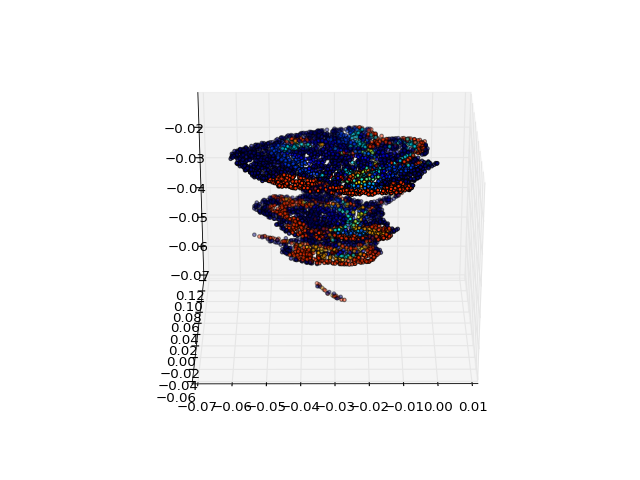

/Users/jtveite/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ss_paths[:,0], ss_paths[:,1], ss_paths[:,2], s=10, c=labels)